## Notebook to develop supervised classification algorithm for identifying snow in PlanetScope 4-band, Landsat 8, Sentinel-2, and MODIS imagery
Rainey Aberle

Adapted from the [SciKit Learn Classifier comparison tutorial](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

### Outline:
1. Set up training data
- PlanetScope
- Landsat 8/9
- Sentinel-2 SR
- Sentinel-2 TOA
    
2. Develop supervised classifiers for EACH site and ALL sites

3. *Optional*
- Test how the number of points used to train impacts model accuracies
- MODIS (not recommended)
- Sentinel-1 (not recommended)

### 0. Initial Set-up: 

#### Import packages, define paths in directory, authenticate Google Earth Engine (GEE), define classification settings.

In [4]:
# -----Import packages
import os
import glob
import numpy as np
import rasterio as rio
import geopandas as gpd
import pandas as pd
import ee
import scipy
import wxee as wx
import xarray as xr
import rioxarray as rxr
from shapely.geometry import Polygon
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn import metrics 
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib
import sys
import pickle
import seaborn as sns
from shapely.geometry import Point, MultiPoint
from joblib import dump, load

In [5]:
# -----Determine whether to save outputs to file
save_outputs = False # = True to save output figures and best classifier 

# -----Define paths in directory
# base directory (path to snow-cover-mapping/)
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'
# output folder for best classifier
out_path = base_path + 'inputs-outputs/'
# output folder for figures
figures_out_path = base_path + 'figures/'
# path to classified points used to train and test classifiers
data_pts_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/classified-points/'

# -----Determine settings
terrain_parameters = False # whether to use terrain parameters (elevation, slope, aspect) in classification
save_figures = True # whether to save output figures

# -----Add path to functions
sys.path.insert(1, base_path + 'functions/')
import pipeline_utils as f

### Authenticate and initialize Google Earth Engine (GEE)

__Note:__ The first time you run the following cell, you will be asked to authenticate your GEE account for use in this notebook. This will send you to an external web page, where you will walk through the GEE authentication workflow and copy an authentication code back in this notebook when prompted. 

In [6]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

### Create dictionary of dataset-specific parameters

In [7]:
dataset_dict = {
    'PlanetScope':{
        'image_scalar': 1e4,
        'bands': {
            'blue': '0',
            'green': '1',
            'red': '2',
            'NIR': '3'
        },
        'no_data_value': -9999,
        'resolution_m': 3,
        'NDSI_bands': ['green', 'NIR'],
        'RGB_bands': ['red', 'green', 'blue']
    },
    
    'Landsat': {
        'image_scalar': 1/2.75e-05,
        'bands': {
            # 'SR_B1': 'ultra_blue',
            'SR_B2': 'blue',
            'SR_B3': 'green',
            'SR_B4': 'red',
            'SR_B5': 'NIR',
            'SR_B6': 'SWIR1',
            'SR_B7': 'SWIR2',
            'QA_PIXEL': 'pixel_quality'
        },
        'no_data_value': -32768,
        'resolution_m': 30,
        'NDSI_bands': ['SR_B3', 'SR_B6'],
        'RGB_bands': ['SR_B4', 'SR_B3', 'SR_B2']
    },
    
    'Sentinel-2_SR':{
        'image_scalar': 1e4,
        'bands': {
            # 'B1': 'aerosols',
            'B2': 'blue',
            'B3': 'green',
            'B4': 'red',
            'B5': 'red_edge1',
            'B6': 'red_edge2',
            # 'B7': 'red_edge3',
            'B8': 'NIR',
            # 'B8A': 'red_edge4',
            # 'B9': 'water_vapor',
            'B11': 'SWIR1',
            'B12': 'SWIR2',
            'QA60': 'cloud_mask'
        },
        'no_data_value': -32768,
        'resolution_m': 10,
        'NDSI_bands': ['B3', 'B11'],
        'RGB_bands': ['B4', 'B3', 'B2']
    },
    
    'Sentinel-2_TOA':{
        'image_scalar': 1e4,
        'bands': {
            # 'B1': 'aerosols',
            'B2': 'blue',
            'B3': 'green',
            'B4': 'red',
            'B5': 'red_edge1',
            'B6': 'red_edge2',
            # 'B7': 'red_edge3',
            'B8': 'NIR',
            # 'B8A': 'red_edge4',
            # 'B9': 'water_vapor',
            'B11': 'SWIR1',
            'B12': 'SWIR2',
            'QA60': 'cloud_mask'
        },
        'no_data_value': -32768,
        'resolution_m': 10,
        'NDSI_bands': ['B3', 'B11'],
        'RGB_bands': ['B4', 'B3', 'B2']
    },
        
}

# save dictionary as pickle file
# with open(out_path + 'datasets_characteristics.pkl', 'wb') as fn:
#     pickle.dump(dataset_dict, fn)
# print('dictionary saved to file: ' + out_path + 'datasets_characteristics.pkl')
# # open dictionary and display
# with open(out_path + 'datasets_characteristics.pkl', 'rb') as fn:
#     dataset_dict = pickle.load(fn)
# dataset_dict

dictionary saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/inputs-outputs/datasets_characteristics.pkl


### Define supervised classification algorithms to test 

In [8]:
# -----Classifier names
names = [
    # "Gaussian Process", # keeps crashing kernel when classifying images!
    "Nearest Neighbors",
    # "Linear SVM", # keeps crashing kernel 
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "Logistic Regression"
]

# -----Classifiers
classifiers = [
    # GaussianProcessClassifier(1.0 * RBF(1.0)),
    KNeighborsClassifier(3),
    # SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(random_state = 0)
]

# -----Define site names
site_names = ['Gulkana', 'SouthCascade', 'Sperry', 'Wolverine']

# -----Define number of folds to use in K-folds cross-validation
num_folds = 10

## 1. Set up training data

### a. PlanetScope

In [9]:
# -----Define dataset for reading dataset dictionary and feature columns
dataset = 'PlanetScope'
feature_cols_PS = ['blue', 'green', 'red', 'NIR', 'NDSI']

# -----Load classified points
os.chdir(data_pts_path)
data_pts_fns = sorted(glob.glob('*.shp'))

# -----Create colormap
color_snow = '#4eb3d3'
color_firn = '#756bb1'
color_ice = '#084081'
color_rock = '#fdbb84'
color_water = '#bdbdbd'
colors = [color_snow, color_firn, color_ice, color_rock, color_water]

# -----Check if training data exist in file
PS_training_data_fn = 'PlanetScope_training_data.pkl'
if os.path.exists(out_path + PS_training_data_fn):
    data_pts_full_PS = pd.read_pickle(out_path + PS_training_data_fn)
    print('training data already exist... loaded from file.')
    
else: 
    
    # Initialize data_pts_full to save info for single classifier (next step)
    data_pts_full_PS = gpd.GeoDataFrame()  
    
    # Loop through sites
    for i, site_name in enumerate(site_names):

        print('----------')
        print(site_name)
        print('----------')

        # determine number of images used for classified points
        num_images = len([s for s in data_pts_fns if (site_name in s) and ('snow.shp' in s)])
        im_dates = [s[len(site_name)+1:len(site_name)+9] for s in data_pts_fns if (site_name in s) and ('snow.shp' in s)]
        # loop through each image
        for j in range(0, num_images):
            # determine image date
            im_date = im_dates[j]
            # load classified points
            data_pts = pd.DataFrame() # dataframe to hold applicable data classes
            # snow
            if len([s for s in data_pts_fns if (site_name in s) and ('snow.shp' in s) and (im_date in s)])>0: # check if class exists for site and date
                data_pts_snow_fn = [s for s in data_pts_fns if (site_name in s) and ('snow.shp' in s) and (im_date in s)][0]
                data_pts_snow = gpd.read_file(data_pts_path + data_pts_snow_fn) # read file
                data_pts_snow['Class'] = 1 # determine class ID
                data_pts = pd.concat([data_pts, data_pts_snow], ignore_index=True) # concatenate to full data points df
                print(data_pts_snow_fn)
            # shadowed snow
            if len([s for s in data_pts_fns if (site_name in s) and ('snow-shadowed.shp' in s)  and (im_date in s)])>0: # check if class exists for site and date
                data_pts_snow_sh_fn = [s for s in data_pts_fns if (site_name in s) and ('snow-shadowed.shp' in s) and (im_date in s)][0]
                data_pts_snow_sh = gpd.read_file(data_pts_path + data_pts_snow_sh_fn) # read file
                data_pts_snow_sh['Class'] = 2 # determine class ID
                data_pts = pd.concat([data_pts, data_pts_snow_sh], ignore_index=True) # concatenate to full data points df
                print(data_pts_snow_sh_fn)
            # firn
            if len([s for s in data_pts_fns if (site_name in s) and ('firn.shp' in s)  and (im_date in s)])>0: # check if class exists for site and date
                data_pts_snow_sh_fn = [s for s in data_pts_fns if (site_name in s) and ('firn.shp' in s) and (im_date in s)][0]
                data_pts_snow_sh = gpd.read_file(data_pts_path + data_pts_snow_sh_fn) # read file
                data_pts_snow_sh['Class'] = 3 # determine class ID
                data_pts = pd.concat([data_pts, data_pts_snow_sh], ignore_index=True) # concatenate to full data points df
                print(data_pts_snow_sh_fn)
            # ice
            if len([s for s in data_pts_fns if (site_name in s) and ('ice.shp' in s) and (im_date in s)])>0: # check if class exists for site and date
                data_pts_ice_fn = [s for s in data_pts_fns if (site_name in s) and ('ice.shp' in s)  and (im_date in s)][0]
                data_pts_ice = gpd.read_file(data_pts_path + data_pts_ice_fn)  # read file
                data_pts_ice['Class'] = 4 # determine class ID
                data_pts = pd.concat([data_pts, data_pts_ice], ignore_index=True) # concatenate to full data points df
                print(data_pts_ice_fn)
            # rock
            if len([s for s in data_pts_fns if (site_name in s) and ('rock.shp' in s) and (im_date in s)])>0: # check if class exists for site and date
                data_pts_rock_fn = [s for s in data_pts_fns if (site_name in s) and ('rock.shp' in s)  and (im_date in s)][0]
                data_pts_rock = gpd.read_file(data_pts_path + data_pts_rock_fn) # read file
                data_pts_rock['Class'] = 5 # determine class ID
                data_pts = pd.concat([data_pts, data_pts_rock], ignore_index=True) # concatenate to full data points df
                print(data_pts_rock_fn)
            # water
            if len([s for s in data_pts_fns if (site_name in s) and ('water.shp' in s)  and (im_date in s)])>0: # check if class exists for site and date
                data_pts_water_fn = [s for s in data_pts_fns if (site_name in s) and ('water.shp' in s) and (im_date in s)][0]
                data_pts_water = gpd.read_file(data_pts_path + data_pts_water_fn) # read file
                data_pts_water['Class'] = 6 # determine class ID
                data_pts = pd.concat([data_pts, data_pts_water], ignore_index=True) # concatenate to full data points df
                print(data_pts_water_fn)

            # Load image
            Idate = data_pts_snow_fn.index('_')+1
            im_fn = site_name+'_'+data_pts_snow_fn[Idate:Idate+11]+'.tif' # image file name
            im_dt = np.datetime64(im_fn.split('_')[1][0:4]+'-'+im_fn.split('_')[1][4:6]+'-'+im_fn.split('_')[1][6:8]) # image capture date
            im = xr.open_dataset(data_pts_path+im_fn) # open image
            # grab image EPSG code
            epsg = str(rxr.open_rasterio(data_pts_path+im_fn).rio.crs.to_epsg()) # grab EPSG code
            # load AOI
            AOI_path = data_pts_path + '../study-sites/'+site_name+'/AOIs/'
            AOI_fn = glob.glob(AOI_path+site_name+'_USGS*.shp')[0]
            AOI = gpd.read_file(AOI_fn)
            AOI = AOI.to_crs('EPSG:'+epsg)
            # load DEM
            DEM_path = AOI_path + '../DEMs/'
            DEM_fn = glob.glob(DEM_path+site_name+'*_DEM*.tif')[0]
            DEM = xr.open_dataset(DEM_fn)
            DEM = DEM.rename({'band_data':'elevation'})
            DEM = DEM.rio.reproject('EPSG:'+epsg)
            # adjust image radiometry
            polygon_top, polygon_bottom, im_fn, im_xr = f.create_AOI_elev_polys(AOI, data_pts_path, [im_fn], DEM)
            im_adj = f.PS_adjust_image_radiometry(im, im_dt, polygon_top, polygon_bottom, AOI, dataset_dict, dataset, site_name, skip_clipped=False)[0]
            
            # Reformat data points coordinates
            # reproject to image epsg
            data_pts = data_pts.to_crs('EPSG:'+epsg) 
            # remove "id" column
            data_pts = data_pts.drop(columns=['id'])
            # change MultiPoint objects to Point objects, remove Null values
            # geoms_points = []
            data_pts['geometry'] = [Point(x.geoms[0]) if type(x)==MultiPoint else None for x in data_pts['geometry'].values]
            data_pts = data_pts.dropna(subset=['geometry'])
            # remove rows containing NaN
            data_pts = data_pts.dropna()
            data_pts = data_pts.reset_index(drop=True)
            # add site_name column
            data_pts['site_name'] = site_name
            # add image date column
            data_pts['PlanetScope_image_date'] = im_dt
            # sample band values at points
            data_pts['blue'] = [im_adj.sel(x=x.coords.xy[0][0], y=x.coords.xy[1][0], method='nearest').blue.values[0] for x in data_pts['geometry'].values]
            data_pts['green'] = [im_adj.sel(x=x.coords.xy[0][0], y=x.coords.xy[1][0], method='nearest').green.values[0] for x in data_pts['geometry'].values]
            data_pts['red'] = [im_adj.sel(x=x.coords.xy[0][0], y=x.coords.xy[1][0], method='nearest').red.values[0] for x in data_pts['geometry'].values]
            data_pts['NIR'] = [im_adj.sel(x=x.coords.xy[0][0], y=x.coords.xy[1][0], method='nearest').NIR.values[0] for x in data_pts['geometry'].values]
            # add NDSI column
            data_pts['NDSI'] = ((data_pts[dataset_dict[dataset]['NDSI_bands'][0]] - data_pts[dataset_dict[dataset]['NDSI_bands'][1]]) 
                                / (data_pts[dataset_dict[dataset]['NDSI_bands'][0]] + data_pts[dataset_dict[dataset]['NDSI_bands'][1]]))
            # if terrain_parameters==True:
            #     # Load DEM
            #     x = im.bounds.left, im.bounds.right, im.bounds.right, im.bounds.left, im.bounds.left
            #     y = im.bounds.bottom, im.bounds.bottom, im.bounds.top, im.bounds.top, im.bounds.bottom
            #     coords = list(zip(x,y))
            #     bb_gdf = gpd.GeoDataFrame({'geometry': [Polygon(coords)]}, crs=im.crs)
            #     DEM, AOI_UTM = f.query_GEE_for_DEM(bb_gdf, im_path, im_fn)
            #     # flatten DEM to 2D
            #     DEM_rd = rd.rdarray(DEM.elevation.data, no_data=-9999) # rich DEM array of DEM
            #     # calculate slope and aspect using DEM
            #     slope = rd.TerrainAttribute(DEM_rd, attrib='slope_degrees')
            #     aspect = rd.TerrainAttribute(DEM_rd, attrib='aspect')
            #     # convert from rdarray to numpy array
            #     slope, aspect = np.array(slope).astype(int), np.array(aspect).astype(int)
            #     # interpolate elevation at coords
            #     f_DEM = scipy.interpolate.interp2d(DEM.x.data, DEM.y.data, DEM)
            #     data_pts['elevation'] = [f_DEM(x[0], x[1])[0] for x in data_pts['coords'].values]
            #     # interpolate slope at coords
            #     f_slope = scipy.interpolate.interp2d(DEM_x, DEM_y, slope) 
            #     data_pts['slope'] = [f_slope(x[0], x[1])[0] for x in data_pts['coords'].values] 
            #     # interpolate aspect at coords
            #     f_aspect = scipy.interpolate.interp2d(DEM_x, DEM_y, aspect) 
            #     data_pts['aspect'] = [f_aspect(x[0], x[1])[0] for x in data_pts['coords'].values]
            #     # add month-of-year (moy) column
            #     data_pts['moy'] = float(im_fn[4:6]) 
            
            # Reproject back to WGS84 for compatibility
            data_pts_WGS = data_pts.to_crs(4326)
            
            # Concatenate to full DataFrame
            data_pts_full_PS = pd.concat([data_pts_full_PS, data_pts_WGS], ignore_index=True)
    
    # Reduce memory usage in data pts
    data_pts_full_PS = f.reduce_memory_usage(data_pts_full_PS)
    
    # Save training data to file
    data_pts_full_PS.to_pickle(out_path + PS_training_data_fn)
    print('PlanetScope training data saved to file:' + out_path + PS_training_data_fn)
    
    # Save feature columns
    feature_cols_fn = out_path + 'PlanetScope_feature_columns.pkl'
    pickle.dump(feature_cols_PS, open(feature_cols_fn, 'wb'))
    print('Feature columns saved to file: ', feature_cols_fn)
    
    # Plot spectral pairplot for training data
    df = data_pts_full_PS
    df['Class'] = df['class'].astype(int)
    df = df.sort_values(by='Class')
    # Assign labels to each class
    df.loc[df['Class']==1, 'Class'] = 'Snow'
    df.loc[df['Class']==2, 'Class'] = 'Snow'
    df.loc[df['Class']==3, 'Class'] = 'Firn'
    df.loc[df['Class']==4, 'Class'] = 'Ice'
    df.loc[df['Class']==5, 'Class'] = 'Bare rock'
    df.loc[df['Class']==6, 'Class'] = 'Water'
    df[feature_cols_PS] = df[feature_cols_PS].astype(object)
    # plot
    fig = sns.pairplot(df, vars=df.columns[4:-1], corner=True, diag_kind='kde', hue='Class', palette=colors)
    plt.show()
    # save figure
    if save_figures:
        fig_fn = base_path + 'figures/spectral_pairplot_PlanetScope_training_data.png'
        fig.savefig(fig_fn, facecolor='w', dpi=300)
        print('figure saved to file:' + fig_fn)

training data already exist... loaded from file.


### b. Landsat

In [10]:
dataset = 'Landsat'
ds_dict = dataset_dict[dataset]

# -----Define bands and feature columns (predictors used in classification)
# Landsat 8 bands: 
# SR_B2=Blue, SR_B3=Green, SR_B4=Red, SR_B5=NIR, SR_B6=SWIR1, SR_B7=SWIR2
band_names = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'QA_PIXEL']
feature_cols_L = band_names[0:-1] + ['NDSI']
# buffer used for clipping images
buffer = 2500 # [m]

# -----Load classified points
os.chdir(data_pts_path)
data_pts_fns = sorted(glob.glob('*.shp'))

# -----Check if training data exist in file
L_training_data_fn = 'Landsat_training_data.pkl'
if os.path.exists(out_path + L_training_data_fn):
    
    data_pts_full_L = pd.read_pickle(out_path + L_training_data_fn)
    print('Landsat training data already exist... loaded from file.')
    
else: 
    
    # Initialize full data points dataframe (for use in next step)
    data_pts_full_L = data_pts_full_PS.copy(deep=True)
    # remove PS bands
    data_pts_full_L = data_pts_full_L.drop(columns=['blue', 'green', 'red', 'NIR', 'NDSI'])
    # initialize band columns
    data_pts_full_L['Landsat_image_date'] = ' '
    data_pts_full_L[feature_cols_L] = 0

    # Loop through sites
    for i, site_name in enumerate(site_names):

        print('----------')
        print(site_name)
        print('----------')

        # Extract PlanetScope image dates from data frame
        im_dates = np.unique(data_pts_full_L.loc[data_pts_full_L['site_name']==site_name]['PlanetScope_image_date'])

        # Load AOI
        AOI_path = base_path + '../study-sites/' + site_name + '/AOIs/' + site_name + '_USGS_*.shp'
        AOI_fn = glob.glob(AOI_path)[0]
        AOI = gpd.read_file(AOI_fn)
        # reproject AOI to WGS 84 for compatibility with images
        AOI_WGS = AOI.to_crs('EPSG:4326')
        # reformat AOI_WGS bounding box as ee.Geometry for clipping images
        AOI_WGS_bb_ee = ee.Geometry.Polygon(
                                [[[AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]]]
                                ])

        # Load images from Earth Engine
        if site_name=='Gulkana':
            im_list = [ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_067016_20210610'),
                       ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_068016_20210804')]
        elif site_name=='SouthCascade':
            im_list = [ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_046026_20210709'),
                       ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_045026_20210819')]
        elif site_name=='Sperry':
            im_list = [ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_041026_20210706'),
                       ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_041026_20210722')]
        elif site_name=='Wolverine':
            im_list = [ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_067018_20180906'),
                       ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_067018_20180906'),
                       ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_068018_20180913'),
                       ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_068018_20180929'),
                       ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_067018_20220629'),
                       ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_067018_20210829')]

        # Clip images and select bands
        im_list_clip = [im.clip(AOI_WGS_bb_ee.buffer(buffer)).select(band_names) for im in im_list]

        # Determine optimal UTM zone EPSG code
        epsg_UTM = f.convert_wgs_to_utm((AOI_WGS.geometry.bounds.maxx[0] - AOI_WGS.geometry.bounds.minx[0]) + AOI_WGS.geometry.bounds.minx[0],
                                         (AOI_WGS.geometry.bounds.maxy[0] - AOI_WGS.geometry.bounds.miny[0]) + AOI_WGS.geometry.bounds.miny[0])

        # Convert images to xarray Datasets, reproject to UTM
        im_list_clip_xr = [im.wx.to_xarray(scale=20, crs='EPSG:4326') 
                           for im in im_list_clip]
        im_list_clip_xr = [im.rio.reproject('EPSG:'+epsg_UTM) for im in im_list_clip_xr]
        # Replace no data values with NaN and account for image scalar
        im_list_clip_xr = [xr.where(im!=ds_dict['no_data_value'], im / ds_dict['image_scalar'],np.nan)
                           for im in im_list_clip_xr]

        # Loop through image dates
        for j, im_date in enumerate(im_dates):

            im = im_list_clip_xr[j]

            # mask clouds
            bands = [str(x) for x in im.data_vars]

            # select df columns for study site and image date
            data_pts = data_pts_full_L.loc[(data_pts_full_L['site_name']==site_name) 
                                            & (data_pts_full_L['PlanetScope_image_date']==im_date)]
            # add Landsat image date
            data_pts['Landsat_image_date'] = str(im.time.data[0])[0:10]
            
            # reproject to UTM
            data_pts = data_pts.to_crs(epsg_UTM)
            
            # sample band values at data points
            for band_name in band_names:
                data_pts[band_name] = [im.sel(x=x.x, y=x.y, method="nearest")[band_name].data[0] 
                                       for x in data_pts['geometry'].values]

            # plot images and data points
            fig1, ax1 = f.plot_xr_RGB_image(im, ['SR_B4', 'SR_B3', 'SR_B2'])
            ax1.scatter([x.x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==1].values], 
                        [x.y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==1].values], c=color_snow, s=1, label='Snow')
            ax1.scatter([x.x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==3].values], 
                        [x.y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==3].values], c=color_firn, s=1, label='Firn')
            ax1.scatter([x.x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==4].values], 
                        [x.y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==4].values], c=color_ice, s=1, label='Ice')
            ax1.scatter([x.x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==5].values], 
                        [x.y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==5].values], c=color_rock, s=1, label='Rock')
            ax1.scatter([x.x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==6].values], 
                        [x.y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==6].values], c=color_water, s=1, label='Water')
            ax1.set_xlabel('Easting [km]')
            ax1.set_ylabel('Northing [km]')
            ax1.legend(loc='best')
            ax1.set_title(data_pts['Landsat_image_date'].values[0])
            plt.show()
            
            # reproject to WGS84 for compatibility
            data_pts = data_pts.to_crs('EPSG:4326')

            # add data_pts back to full df
            data_pts_full_L.loc[(data_pts_full_L['site_name']==site_name) 
                                 & (data_pts_full_L['PlanetScope_image_date']==im_date)] = data_pts

    # Remove no data points
    data_pts_full_L = data_pts_full_L.dropna().reset_index(drop=True)

    # Add NDSI column (G-SWIR)/(G+SWIR)
    NDSI_bands = dataset_dict[dataset]['NDSI_bands']
    data_pts_full_L['NDSI'] = ((data_pts_full_L[NDSI_bands[0]] - data_pts_full_L[NDSI_bands[1]]) 
                             / (data_pts_full_L[NDSI_bands[0]] + data_pts_full_L[NDSI_bands[1]]))

    # don't use shadowed snow (where class==shadowed snow, make it snow)
    data_pts_full_L.loc[data_pts_full_L['class']==2, 'class'] = 1
                              
    # Reduce memory usage in df
    data_pts_full_L = f.reduce_memory_usage(data_pts_full_L)

    # Save training data to file
    data_pts_full_L.to_pickle(out_path + L_training_data_fn)
    print('Landsat training data saved to file:' + out_path + L_training_data_fn)

    # Save feature columns
    feature_cols_fn = out_path + 'Landsat_feature_cols.pkl'
    pickle.dump(feature_cols_L, open(feature_cols_fn, 'wb'))
    print('Feature columns saved to file: ', feature_cols_fn)
    
    # Plot spectral pairplot for training data
    df = data_pts_full_L
    df['Class'] = df['class'].astype(int)
    df = df.sort_values(by='Class')
    # Assign labels to each class
    df.loc[df['Class']==1, 'Class'] = 'Snow'
    df.loc[df['Class']==2, 'Class'] = 'Snow'
    df.loc[df['Class']==3, 'Class'] = 'Firn'
    df.loc[df['Class']==4, 'Class'] = 'Ice'
    df.loc[df['Class']==5, 'Class'] = 'Bare rock'
    df.loc[df['Class']==6, 'Class'] = 'Water'
    df[feature_cols_L] = df[feature_cols_L].astype(float)
    # plot
    fig = sns.pairplot(df, vars=df.columns[5:-1], corner=True, diag_kind='kde', hue='Class', palette=colors)
    plt.show()
    # save figure
    if save_figures:
        fig_fn = base_path + 'figures/spectral_pairplot_Landsat_training_data.png'
        fig.savefig(fig_fn, facecolor='w', dpi=300)
        print('figure saved to file:' + fig_fn)

Landsat training data already exist... loaded from file.


### c. Sentinel-2 SR

In [11]:
dataset='Sentinel-2_SR'
ds_dict = dataset_dict[dataset]

# -----Define bands and feature columns (predictors used in classification)
# Sentinel-2 bands: 
# B2=Blue, B3=Green, B4=Red, B5=Red Edge 1, B6=Red Edge 2, B7=Red Edge 3, B8=NIR, 
# B8A=Red Edge 4, B9=Water vapor, B11=SWIR1, B12=SWIR2
band_names = [band for band in ds_dict['bands'] if 'QA' not in band]
feature_cols_S2 = band_names + ['NDSI']
# buffer used for clipping images
buffer = [1000, 3000, 1000, 2500] # [m]

# -----Check if training data exist in file
S2_SR_training_data_fn = 'Sentinel-2_SR_training_data.pkl'
if os.path.exists(out_path + S2_SR_training_data_fn):
    
    data_pts_full_S2_SR = pd.read_pickle(out_path + S2_SR_training_data_fn)
    print('Sentinel-2 SR training data already exist... loaded from file.')
    
else: 
    
    # Initialize full data points dataframe (for use in next step)
    data_pts_full_S2_SR = data_pts_full_PS.copy(deep=True)
    data_pts_full_S2_SR = data_pts_full_S2_SR.drop(columns=['blue', 'red', 'green', 'NIR', 'NDSI'])
    data_pts_full_S2_SR[band_names] = " " # initialize band columns

    # Loop through sites
    for i, site_name in enumerate(site_names):
    
        print('----------')
        print(site_name)
        print('----------')

        # Extract PlanetScope image dates from data frame
        im_dates = np.unique(data_pts_full_S2_SR.loc[data_pts_full_S2_SR['site_name']==site_name]['PlanetScope_image_date'])
        im_dates = [x for x in im_dates if x.astype('datetime64[Y]')!=np.datetime64('2018')] # no 2018 images available for Sentinel-2 SR

        # Load AOI
        AOI_path = base_path + '../study-sites/' + site_name + '/AOIs/' + site_name + '_USGS_*.shp'
        AOI_fn = glob.glob(AOI_path)[0]
        AOI = gpd.read_file(AOI_fn)
        # reproject AOI to WGS 84 for compatibility with images
        AOI_WGS = AOI.to_crs(4326)
        # reformat AOI_WGS bounding box as ee.Geometry for clipping images
        AOI_WGS_bb_ee = ee.Geometry.Polygon(
                                [[[AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]]]
                                ])

        # Load images from Earth Engine
        if site_name=='Gulkana':
            im_list = [ee.Image('COPERNICUS/S2_SR_HARMONIZED/20210615T211519_20210615T211514_T06VWR'),
                       ee.Image('COPERNICUS/S2_SR_HARMONIZED/20210802T212531_20210802T212655_T06VWR')]
        elif site_name=='SouthCascade':
            im_list = [ee.Image('COPERNICUS/S2_SR_HARMONIZED/20210704T190921_20210704T191755_T10UFU'),
                       ee.Image('COPERNICUS/S2_SR_HARMONIZED/20210825T185919_20210825T190431_T10UFU')]
        elif site_name=='Sperry':
            im_list = [ee.Image('COPERNICUS/S2_SR_HARMONIZED/20210630T183919_20210630T184143_T11UQP'),
                       ee.Image('COPERNICUS/S2_SR_HARMONIZED/20210730T183919_20210730T184810_T11UQP')]
        elif site_name=='Wolverine':
            im_list = [ee.Image('COPERNICUS/S2_SR_HARMONIZED/20210615T211519_20210615T211514_T06VUN'), 
                       ee.Image('COPERNICUS/S2_SR_HARMONIZED/20210829T211521_20210829T211714_T06VUN')]
            
        # Clip images and select bands
        im_list_clip = [im.clip(AOI_WGS_bb_ee.buffer(buffer[i])).select(band_names) for im in im_list]
        
        # Convert images to xarray Datasets
        im_list_clip_xr = [im.wx.to_xarray(scale=15, crs='EPSG:4326') for im in im_list_clip]
        # Determine optimal UTM zone EPSG code
        epsg_UTM = f.convert_wgs_to_utm((AOI_WGS.geometry.bounds.maxx[0] - AOI_WGS.geometry.bounds.minx[0]) + AOI_WGS.geometry.bounds.minx[0],
                                         (AOI_WGS.geometry.bounds.maxy[0] - AOI_WGS.geometry.bounds.miny[0]) + AOI_WGS.geometry.bounds.miny[0])
        # Reproject to UTM
        im_list_clip_xr = [im.rio.reproject('EPSG:'+epsg_UTM) for im in im_list_clip_xr]
        # Replace no data values with NaN, account for image scalar
        im_list_clip_xr = [xr.where(im!=ds_dict['no_data_value'], im / ds_dict['image_scalar'], np.nan)
                           for im in im_list_clip_xr]
        
        # Loop through image dates
        for j, im_date in enumerate(im_dates):

            im = im_list_clip_xr[j]
            
            # select df columns for study site and image date
            data_pts = data_pts_full_S2_SR.loc[(data_pts_full_S2_SR['site_name']==site_name) 
                                            & (data_pts_full_S2_SR['PlanetScope_image_date']==im_date)]
            
            # add Sentinel-2 image date
            data_pts['Sentinel-2_image_date'] = str(im.time.data[0])[0:10]
            
            # reproject to UTM
            data_pts = data_pts.to_crs(epsg_UTM)
            
            # sample band values at data points
            for band_name in band_names:
                data_pts[band_name] = [im.sel(x=x.x, y=x.y, method="nearest")[band_name].data[0] 
                                       for x in data_pts['geometry'].values]

            # plot images and data points
            fig1, ax1 = f.plot_xr_RGB_image(im, ['B4', 'B3', 'B2'])
            ax1.scatter([x.x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==1].values], 
                        [x.y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==1].values], c=color_snow, s=1, label='Snow')
            ax1.scatter([x.x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==3].values], 
                        [x.y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==3].values], c=color_firn, s=1, label='Firn')
            ax1.scatter([x.x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==4].values], 
                        [x.y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==4].values], c=color_ice, s=1, label='Ice')
            ax1.scatter([x.x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==5].values], 
                        [x.y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==5].values], c=color_rock, s=1, label='Rock')
            ax1.scatter([x.x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==6].values], 
                        [x.y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==6].values], c=color_water, s=1, label='Water')
            ax1.set_xlabel('Easting [km]')
            ax1.set_ylabel('Northing [km]')
            ax1.legend(loc='best')
            ax1.set_title(data_pts['Sentinel-2_image_date'].values[0])
            plt.show()
            
             # reproject to WGS84 for compatibility
            data_pts = data_pts.to_crs('EPSG:4326')
            
            # add data_pts back to full df
            data_pts_full_S2_SR.loc[(data_pts_full_S2_SR['site_name']==site_name) 
                                 & (data_pts_full_S2_SR['PlanetScope_image_date']==im_date)] = data_pts

    # remove empty rows (from NaN values and 2018 imagery)
    data_pts_full_S2_SR = data_pts_full_S2_SR.dropna().reset_index(drop=True)
    I = [i for i,x in enumerate(data_pts_full_S2_SR['B3'].values) if type(x)==str] # indices of rows to drop
    data_pts_full_S2_SR = data_pts_full_S2_SR.drop(I)
    
    # Add NDSI column
    data_pts_full_S2_SR[feature_cols_S2[0:-1]] = data_pts_full_S2_SR[feature_cols_S2[0:-1]].astype(float)
    data_pts_full_S2_SR['NDSI'] = ((data_pts_full_S2_SR[ds_dict['NDSI_bands'][0]] - data_pts_full_S2_SR[ds_dict['NDSI_bands'][1]]) / 
                                (data_pts_full_S2_SR[ds_dict['NDSI_bands'][0]] + data_pts_full_S2_SR[ds_dict['NDSI_bands'][1]]))
    
    # don't use shadowed snow (where class==shadowed snow, make it snow)
    data_pts_full_S2_SR.loc[data_pts_full_S2_SR['class']==2, 'class'] = 1
    
    
    # Reduce memory usage in df
    data_pts_full_S2_SR = f.reduce_memory_usage(data_pts_full_S2_SR)
    
    # Save training data to file
    data_pts_full_S2_SR.to_pickle(out_path + S2_SR_training_data_fn)
    print('Sentinel-2 SR training data saved to file:' + out_path + S2_SR_training_data_fn)
    
    # Save feature columns
    feature_cols_fn = out_path + 'Sentinel-2_SR_feature_cols.pkl'
    pickle.dump(feature_cols_S2, open(feature_cols_fn, 'wb'))
    print('Feature columns saved to file: ', feature_cols_fn)
    
    # Plot spectral pairplot for training data
    df = data_pts_full_S2_SR
    df['Class'] = df['class'].astype(int)
    df = df.sort_values(by='Class')
    # Assign labels to each class
    df.loc[df['Class']==1, 'Class'] = 'Snow'
    df.loc[df['Class']==2, 'Class'] = 'Snow'
    df.loc[df['Class']==3, 'Class'] = 'Firn'
    df.loc[df['Class']==4, 'Class'] = 'Ice'
    df.loc[df['Class']==5, 'Class'] = 'Bare rock'
    df.loc[df['Class']==6, 'Class'] = 'Water'
    df[feature_cols_S2] = df[feature_cols_S2].astype(float)
    # plot
    fig = sns.pairplot(df, vars=df.columns[5:-1], corner=True, diag_kind='kde', hue='Class', palette=colors)
    plt.show()
    # save figure
    if save_figures:
        fig_fn = base_path + 'figures/spectral_pairplot_Sentinel-2_SR_training_data.png'
        fig.savefig(fig_fn, facecolor='w', dpi=300)
        print('figure saved to file:' + fig_fn)

Sentinel-2 SR training data already exist... loaded from file.


/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  setstate(state)


### d. Sentinel-2 TOA

In [12]:
dataset='Sentinel-2_TOA'
ds_dict = dataset_dict[dataset]

# -----Define bands and feature columns (predictors used in classification)
# Sentinel-2 bands: 
# B2=Blue, B3=Green, B4=Red, B5=Red Edge 1, B6=Red Edge 2, B7=Red Edge 3, B8=NIR, 
# B8A=Red Edge 4, B9=Water vapor, B11=SWIR1, B12=SWIR2
band_names = [band for band in ds_dict['bands'] if 'QA' not in band]
feature_cols_S2_TOA = band_names + ['NDSI']
# buffer used for clipping images
buffer = [1000, 3000, 1000, 2500] # [m]

# -----Check if training data exist in file
S2_TOA_training_data_fn = 'Sentinel-2_TOA_training_data.pkl'
if os.path.exists(out_path + S2_TOA_training_data_fn):
    
    data_pts_full_S2_TOA = pd.read_pickle(out_path + S2_TOA_training_data_fn)
    print('Sentinel-2 TOA training data already exist... loaded from file.')
    
else: 
    
    # Initialize full data points dataframe (for use in next step)
    data_pts_full_S2_TOA = data_pts_full_PS.copy(deep=True)
    data_pts_full_S2_TOA = data_pts_full_S2_TOA.drop(columns=['blue', 'red', 'green', 'NIR', 'NDSI'])
    data_pts_full_S2_TOA[band_names] = " " # initialize band columns

    # Loop through sites
    for i, site_name in enumerate(site_names):
    
        print('----------')
        print(site_name)
        print('----------')

        # Extract PlanetScope image dates from data frame
        im_dates = np.unique(data_pts_full_S2_TOA.loc[data_pts_full_S2_TOA['site_name']==site_name]['PlanetScope_image_date'])

        # Load AOI
        AOI_path = base_path + '../study-sites/' + site_name + '/AOIs/' + site_name + '_USGS_*.shp'
        AOI_fn = glob.glob(AOI_path)[0]
        AOI = gpd.read_file(AOI_fn)
        # reproject AOI to WGS 84 for compatibility with images
        AOI_WGS = AOI.to_crs(4326)
        # reformat AOI_WGS bounding box as ee.Geometry for clipping images
        AOI_WGS_bb_ee = ee.Geometry.Polygon(
                                [[[AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]]]
                                ])

        # Load images from Earth Engine
        if site_name=='Gulkana':
            im_list = [ee.Image('COPERNICUS/S2_HARMONIZED/20210615T211519_20210615T211514_T06VWR'),
                       ee.Image('COPERNICUS/S2_HARMONIZED/20210802T212531_20210802T212655_T06VWR')]
        elif site_name=='SouthCascade':
            im_list = [ee.Image('COPERNICUS/S2_HARMONIZED/20210704T190921_20210704T191755_T10UFU'),
                       ee.Image('COPERNICUS/S2_HARMONIZED/20210825T185919_20210825T190431_T10UFU')]
        elif site_name=='Sperry':
            im_list = [ee.Image('COPERNICUS/S2_HARMONIZED/20210630T183919_20210630T184143_T11UQP'),
                       ee.Image('COPERNICUS/S2_HARMONIZED/20210730T183919_20210730T184810_T11UQP')]
        elif site_name=='Wolverine':
            im_list = [ee.Image('COPERNICUS/S2_HARMONIZED/20180904T211511_20180904T211511_T06VUN'),
                       ee.Image('COPERNICUS/S2_HARMONIZED/20180904T211511_20180904T211511_T06VUN'),
                       ee.Image('COPERNICUS/S2_HARMONIZED/20180912T212519_20180912T212643_T06VUN'),
                       ee.Image('COPERNICUS/S2_HARMONIZED/20180929T211509_20180929T211507_T06VUN'),
                       ee.Image('COPERNICUS/S2_HARMONIZED/20210615T211519_20210615T211514_T06VUN'),
                       ee.Image('COPERNICUS/S2_HARMONIZED/20210829T211521_20210829T211714_T06VUN')]
            
        # Clip images and select bands
        im_list_clip = [im.clip(AOI_WGS_bb_ee.buffer(buffer[i])).select(band_names) for im in im_list]
        
        # Convert images to xarray Datasets
        im_list_clip_xr = [im.wx.to_xarray(scale=15, crs='EPSG:4326') for im in im_list_clip]
        # Determine optimal UTM zone EPSG code
        epsg_UTM = f.convert_wgs_to_utm((AOI_WGS.geometry.bounds.maxx[0] - AOI_WGS.geometry.bounds.minx[0]) + AOI_WGS.geometry.bounds.minx[0],
                                         (AOI_WGS.geometry.bounds.maxy[0] - AOI_WGS.geometry.bounds.miny[0]) + AOI_WGS.geometry.bounds.miny[0])
        # Reproject to UTM
        im_list_clip_xr = [im.rio.reproject('EPSG:'+epsg_UTM) for im in im_list_clip_xr]
        # Replace no data values with NaN, account for image scalar
        im_list_clip_xr = [xr.where(im!=ds_dict['no_data_value'], im / ds_dict['image_scalar'], np.nan)
                           for im in im_list_clip_xr]
        
        # Loop through image dates
        for j, im_date in enumerate(im_dates):

            im = im_list_clip_xr[j]
            
            # select df columns for study site and image date
            data_pts = data_pts_full_S2_TOA.loc[(data_pts_full_S2_TOA['site_name']==site_name) 
                                                & (data_pts_full_S2_TOA['PlanetScope_image_date']==im_date)]
            
            # add Sentinel-2 image date
            data_pts['Sentinel-2_image_date'] = str(im.time.data[0])[0:10]
            
            # reproject to UTM
            data_pts = data_pts.to_crs(epsg_UTM)
            
            # sample band values at data points
            for band_name in band_names:
                data_pts[band_name] = [im.sel(x=x.x, y=x.y, method="nearest")[band_name].data[0] 
                                       for x in data_pts['geometry'].values]

            # plot images and data points
            fig1, ax1 = f.plot_xr_RGB_image(im, ['B4', 'B3', 'B2'])
            ax1.scatter([x.x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==1].values], 
                        [x.y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==1].values], c=color_snow, s=1, label='Snow')
            ax1.scatter([x.x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==3].values], 
                        [x.y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==3].values], c=color_firn, s=1, label='Firn')
            ax1.scatter([x.x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==4].values], 
                        [x.y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==4].values], c=color_ice, s=1, label='Ice')
            ax1.scatter([x.x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==5].values], 
                        [x.y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==5].values], c=color_rock, s=1, label='Rock')
            ax1.scatter([x.x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==6].values], 
                        [x.y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==6].values], c=color_water, s=1, label='Water')
            ax1.set_xlabel('Easting [km]')
            ax1.set_ylabel('Northing [km]')
            ax1.legend(loc='best')
            ax1.set_title(data_pts['Sentinel-2_image_date'].values[0])
            plt.show()
            
             # reproject to WGS84 for compatibility
            data_pts = data_pts.to_crs('EPSG:4326')
            
            # add data_pts back to full df
            data_pts_full_S2_TOA.loc[(data_pts_full_S2_TOA['site_name']==site_name) 
                                     & (data_pts_full_S2_TOA['PlanetScope_image_date']==im_date)] = data_pts

    # remove empty rows (from NaN values and 2018 imagery)
    data_pts_full_S2_SR = data_pts_full_S2_SR.dropna().reset_index(drop=True)
    I = [i for i,x in enumerate(data_pts_full_S2_SR['B3'].values) if type(x)==str] # indices of rows to drop
    data_pts_full_S2_SR = data_pts_full_S2_SR.drop(I)
    
    # Add NDSI column
    data_pts_full_S2_TOA = data_pts_full_S2_TOA.dropna()
    data_pts_full_S2_TOA[ds_dict['NDSI_bands']] = data_pts_full_S2_TOA[ds_dict['NDSI_bands']].astype(float)
    data_pts_full_S2_TOA['NDSI'] = ((data_pts_full_S2_TOA[ds_dict['NDSI_bands'][0]] - data_pts_full_S2_TOA[ds_dict['NDSI_bands'][1]]) / 
                                    (data_pts_full_S2_TOA[ds_dict['NDSI_bands'][0]] + data_pts_full_S2_TOA[ds_dict['NDSI_bands'][1]]))
    
    # don't use shadowed snow (where class==shadowed snow, make it snow)
    data_pts_full_S2_TOA.loc[data_pts_full_S2_TOA['class']==2, 'class'] = 1
    
    # Reduce memory usage in df
    data_pts_full_S2_TOA = f.reduce_memory_usage(data_pts_full_S2_TOA)
    
    # Save training data to file
    data_pts_full_S2_TOA.to_pickle(out_path + S2_TOA_training_data_fn)
    print('Sentinel-2 TOA training data saved to file:' + out_path + S2_TOA_training_data_fn)
    
    # Save feature columns
    feature_cols_fn = out_path + 'Sentinel-2_TOA_feature_cols.pkl'
    pickle.dump(feature_cols_S2, open(feature_cols_fn, 'wb'))
    print('Feature columns saved to file: ', feature_cols_fn)
    
    # Plot spectral pairplot for training data
    df = data_pts_full_S2_TOA
    df['Class'] = df['class'].astype(int)
    df = df.sort_values(by='Class')
    # Assign labels to each class
    df.loc[df['Class']==1, 'Class'] = 'Snow'
    df.loc[df['Class']==2, 'Class'] = 'Snow'
    df.loc[df['Class']==3, 'Class'] = 'Firn'
    df.loc[df['Class']==4, 'Class'] = 'Ice'
    df.loc[df['Class']==5, 'Class'] = 'Bare rock'
    df.loc[df['Class']==6, 'Class'] = 'Water'
    df[feature_cols_S2] = df[feature_cols_S2].astype(float)
    # plot
    fig = sns.pairplot(df, vars=df.columns[5:-1], corner=True, diag_kind='kde', hue='Class', palette=colors)
    plt.show()
    # save figure
    if save_figures:
        fig_fn = base_path + 'figures/spectral_pairplot_Sentinel-2_TOA_training_data.png'
        fig.savefig(fig_fn, facecolor='w', dpi=300)
        print('figure saved to file:' + fig_fn)

Sentinel-2 TOA training data already exist... loaded from file.


/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  setstate(state)


## 2. Develop supervised classifiers for each dataset

Use classified points at each site to determine the best classifiers for EACH site and for ALL sites using K-folds cross-validation. 

----------
PlanetScope
----------
Testing one classifier for ALL sites...
Nearest Neighbors
RBF SVM
Decision Tree
Random Forest


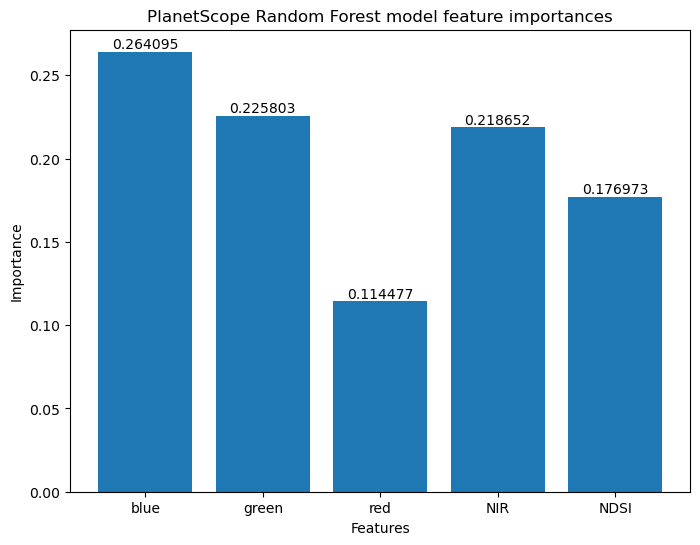

    figure saved to file
Neural Net
AdaBoost
Naive Bayes
QDA
Logistic Regression


/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

            Classifier  Accuracy  Kappa_score
0    Nearest Neighbors  0.953672     0.929712
1              RBF SVM  0.947479     0.919343
2        Decision Tree  0.943219     0.912958
3        Random Forest  0.940639     0.908903
4           Neural Net  0.920895     0.878009
5             AdaBoost  0.710414     0.579411
6          Naive Bayes  0.825398     0.755497
7                  QDA  0.909538     0.867911
8  Logistic Regression  0.930315     0.892813

Best accuracy classifier: Nearest Neighbors
Most accurate classifier saved to file:  /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/inputs-outputs/PlanetScope_classifier_all_sites.joblib
----------
Landsat
----------
Testing one classifier for ALL sites...
Nearest Neighbors
RBF SVM
Decision Tree
Random Forest


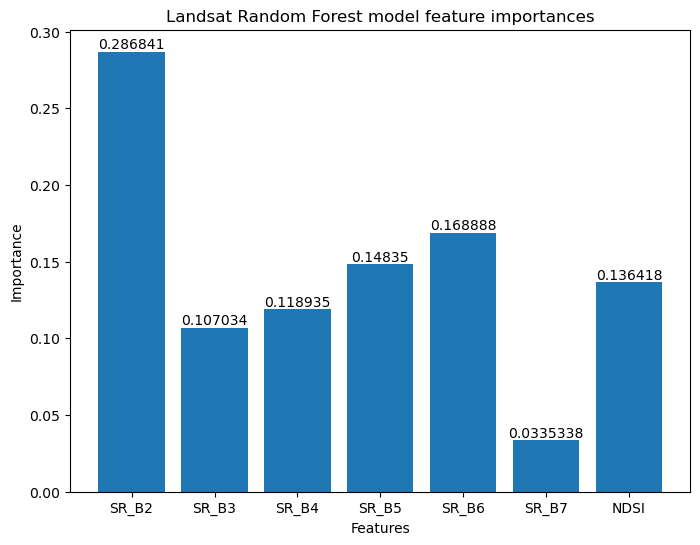

    figure saved to file
Neural Net
AdaBoost
Naive Bayes
QDA
Logistic Regression


/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

            Classifier  Accuracy  Kappa_score
0    Nearest Neighbors  0.943766     0.907506
1              RBF SVM  0.926213     0.877569
2        Decision Tree  0.913212     0.854383
3        Random Forest  0.911829     0.852353
4           Neural Net  0.886476     0.808199
5             AdaBoost  0.770692     0.600222
6          Naive Bayes  0.737607     0.621902
7                  QDA  0.897448     0.837708
8  Logistic Regression  0.899478     0.831615

Best accuracy classifier: Nearest Neighbors
Most accurate classifier saved to file:  /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/inputs-outputs/Landsat_classifier_all_sites.joblib
----------
Sentinel-2_SR
----------
Testing one classifier for ALL sites...
Nearest Neighbors
RBF SVM
Decision Tree
Random Forest


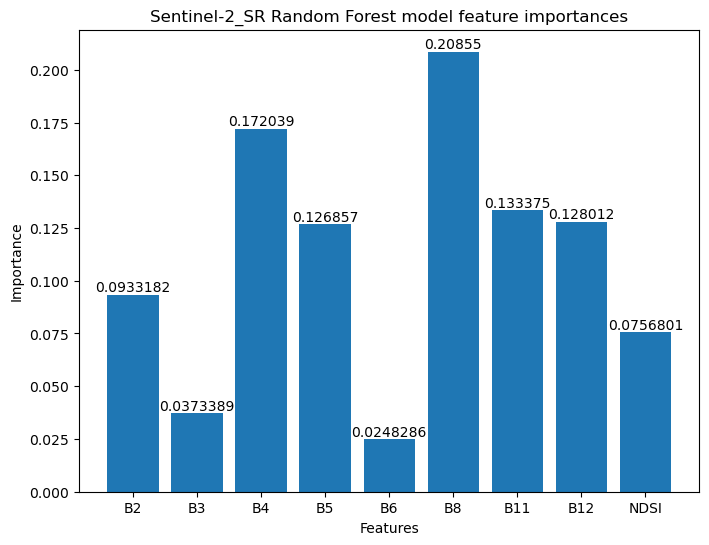

    figure saved to file
Neural Net
AdaBoost
Naive Bayes
QDA
Logistic Regression
            Classifier  Accuracy  Kappa_score
0    Nearest Neighbors  0.978925     0.964890
1              RBF SVM  0.971872     0.953262
2        Decision Tree  0.971374     0.952461
3        Random Forest  0.966146     0.943463
4           Neural Net  0.955194     0.925076
5             AdaBoost  0.726338     0.546246
6          Naive Bayes  0.951294     0.919596
7                  QDA  0.975107     0.958469
8  Logistic Regression  0.962080     0.936692

Best accuracy classifier: Nearest Neighbors
Most accurate classifier saved to file:  /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/inputs-outputs/Sentinel-2_SR_classifier_all_sites.joblib
----------
Sentinel-2_TOA
----------
Testing one classifier for ALL sites...
Nearest Neighbors
RBF SVM
Decision Tree
Random Forest


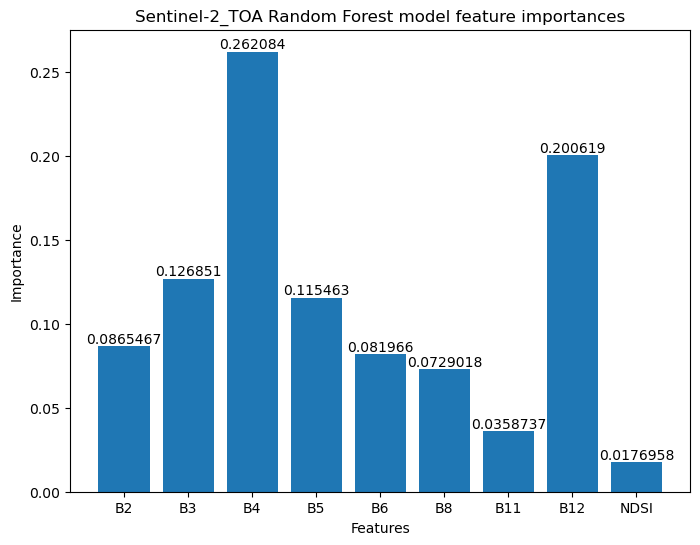

    figure saved to file
Neural Net
AdaBoost
Naive Bayes
QDA
Logistic Regression


/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

            Classifier  Accuracy  Kappa_score
0    Nearest Neighbors  0.965657     0.943415
1              RBF SVM  0.948648     0.915065
2        Decision Tree  0.941276     0.902566
3        Random Forest  0.941114     0.902118
4           Neural Net  0.917300     0.861684
5             AdaBoost  0.866110     0.788034
6          Naive Bayes  0.750688     0.644598
7                  QDA  0.893408     0.835769
8  Logistic Regression  0.933744     0.889661

Best accuracy classifier: Nearest Neighbors
Most accurate classifier saved to file:  /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/inputs-outputs/Sentinel-2_TOA_classifier_all_sites.joblib


/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
save_outputs = True

# -----Define datasets to test
datasets = ['PlanetScope', 'Landsat', 'Sentinel-2_SR', 'Sentinel-2_TOA']#, 'MODIS']

# -----Loop through datasets
for dataset in datasets:
    
    print('----------')
    print(dataset)
    print('----------')
    
    # Define variables and dataset prefix to use in file names based on dataset
    if dataset=='PlanetScope':
        data_pts_full = data_pts_full_PS.dropna().reset_index(drop=True)
        feature_cols = feature_cols_PS
    elif dataset=='Landsat':
        data_pts_full = data_pts_full_L.dropna().reset_index(drop=True)
        feature_cols = feature_cols_L
    elif dataset=='Sentinel-2_SR':
        data_pts_full = data_pts_full_S2_SR.dropna().reset_index(drop=True)
        feature_cols = feature_cols_S2
    elif dataset=='Sentinel-2_TOA':
        data_pts_full = data_pts_full_S2_TOA.dropna().reset_index(drop=True)
        feature_cols = feature_cols_S2
    elif dataset=='MODIS':
        dataset_prefix = 'M'
        data_pts_full = data_pts_full_M.dropna().reset_index(drop=True)
        feature_cols = feature_cols_M
        
    # -----Test one classifier for each site
    # print('Testing one classifier for EACH site...')
    # for i in range(len(site_names)):
    #     print(site_names[i])
    #     # Select all columns in data_pts_full_PS for site
    #     data_pts = data_pts_full.loc[data_pts_full['site_name']==site_names[i]]
    #     data_pts = data_pts.dropna().reset_index(drop=True) # reset indixes
    #     # Split data points into features (band values / terrain parameters) and target variable (class)
    #     X = data_pts[feature_cols] # features
    #     y = data_pts['class'].astype(int) # label
    #     # Iterate over classifiers
    #     accuracy = np.zeros(len(classifiers)) # mean accuracy
    #     K = np.zeros(len(classifiers)) # mean Kappa score
    #     j=0
    #     for name, clf in zip(names, classifiers):
    #         # Conduct K-Fold cross-validation
    #         kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
#             accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
#             K_folds = np.zeros(num_folds) # kappa score for all MC simulations
#             k=0 # iteration counter
#             # enumerate the splits and summarize the distributions
#             for train_ix, test_ix in kfold.split(X):
#                 # select rows
#                 X_train, X_test = X.loc[train_ix], X.loc[test_ix]
#                 y_train, y_test = y[train_ix], y[test_ix]
#                 # Train classifier
#                 clf.fit(X_train, y_train)
#                 # Predict class values using trained classifier
#                 y_pred = clf.predict(X_test)
#                 # Calculate overall accuracy
#                 accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
#                 # Calculate Kappa score
#                 K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)
#                 k+=1

#             # Calculate mean accuracy and Kappa score
#             accuracy[j] = np.nanmean(accuracy_folds)
#             K[j] = np.nanmean(K_folds)
#             j+=1

#         # Determine best classifier based on accuracy
#         results = pd.DataFrame()
#         results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
#         clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
#         clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
#         print(results)
#         print('')
#         print('Best accuracy classifier: ' + clf_best_name)

#         # Save most accurate classifier
#         if save_outputs==True:
#             clf_fn = out_path + dataset_prefix + '_classifier_'+site_names[i]+'.sav'
#             pickle.dump(clf_best, open(clf_fn, 'wb'))
#             print('Most accurate classifier saved to file: ',clf_fn)
            
#         print(' ')
        
    # -----Test one classifier for all sites
    print('Testing one classifier for ALL sites...')
    # data_pts_full = data_pts_full.dropna()
    X = data_pts_full[feature_cols].astype(float) # features
    y = data_pts_full['class'].astype(int) # labels
    
    # Iterate over classifiers
    num_folds = 10
    accuracy = np.zeros(len(classifiers)) # mean accuracy
    K = np.zeros(len(classifiers)) # mean Kappa score
    CM = np.zeros((4, 4, len(classifiers))) # confusion matrix
    j=0
    for name, clf in zip(names, classifiers):

        print(name)

        # Conduct K-Fold cross-validation
        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
        accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
        K_folds = np.zeros(num_folds) # kappa score for all MC simulations
        # CM_folds = np.zeros((4, 4, num_folds)) # confusion matrix for all folds
        # enumerate the splits and summarize the distributions
        k=0
        for train_ix, test_ix in kfold.split(X):

            # select rows
            X_train, X_test = X.loc[train_ix], X.loc[test_ix]
            y_train, y_test = y[train_ix], y[test_ix]

            # Train classifier
            clf.fit(X_train, y_train)

            # Predict class values using trained classifier
            y_pred = clf.predict(X_test)

            # Calculate overall accuracy
            accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
            # Calculate Kappa score
            K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)
            # Calculate confusion matrix
            # CM_folds[:, :, k] = metrics.confusion_matrix(y_test, y_pred)
            
            k+=1

        # Calculate mean accuracy and Kappa score
        accuracy[j] = np.nanmean(accuracy_folds)
        K[j] = np.nanmean(K_folds)
        # CM[:,:,j] = np.nansum(CM_folds, axis=2)
        
        # Determine feature importance using Random Forest model
        if name=="Random Forest":
            importances = clf.feature_importances_
            # print('    Feature importances:')
            # [print('   ', x, y) for x, y in zip(feature_cols, importances)]
            fig, ax = plt.subplots(1,1, figsize=(8,6))
            bars = ax.bar(np.arange(len(feature_cols)), importances)
            ax.bar_label(bars)
            ax.set_xticks(np.arange(len(feature_cols)))
            ax.set_xticklabels(feature_cols)
            ax.set_xlabel('Features')
            ax.set_ylabel('Importance')
            ax.set_title(dataset+' Random Forest model feature importances')
            plt.show()
            fig.savefig(figures_out_path + 'RandomForest_feature_importances_'+dataset+'.png', 
                     dpi=300, facecolor='w')
            print('    figure saved to file')
        j+=1

    # -----Determine best classifier based on accuracy
    results = pd.DataFrame()
    results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
    clf_best_name = names[np.where(K==np.max(K))[0][0]]
    clf_best = classifiers[np.where(K==np.max(K))[0][0]]
    print(results)
    print('')
    print('Best accuracy classifier: ' + clf_best_name)

    # -----Save most accurate classifier
    if save_outputs==True:
        clf_fn = out_path + dataset + '_classifier_all_sites.joblib'
        dump(clf_best, clf_fn)
        print('Most accurate classifier saved to file: ',clf_fn)
    
    # -----Print confusion matrix
    # CM_copy = pd.DataFrame(columns=['Snow', 'Shadowed_snow', 'Ice', 'Bare_ground', 'Water', 'All_snow'])
    # CM_copy['Snow'] = CM[:,0,0]
    # CM_copy['Shadowed_snow'] = CM[:,1,0]
    # CM_copy['Ice'] = CM[:,2,0]
    # CM_copy['Bare_ground'] = CM[:,3,0]
    # CM_copy['Water'] = CM[:,4,0]
    # CM_copy['All_snow'] = CM_copy['Snow'] + CM_copy['Shadowed_snow']
    # CM_copy = CM_copy.drop(columns=['Snow', 'Shadowed_snow'])
    # print(CM_copy)
    
    # -----Plot spectral pairplot for model predictions
    # df = data_pts_full
    # df = df.sort_values(by='class')
    # # predict class for each training point
    # df['Predicted Class'] = clf_best.predict(X).astype(object)
    # # Assign labels to each class
    # df.loc[df['Predicted Class']==1, 'Predicted Class'] = 'Snow'
    # df.loc[df['Predicted Class']==2, 'Predicted Class'] = 'Snow'
    # df.loc[df['Predicted Class']==3, 'Predicted Class'] = 'Ice'
    # df.loc[df['Predicted Class']==4, 'Predicted Class'] = 'Bare rock'
    # df.loc[df['Predicted Class']==5, 'Predicted Class'] = 'Water'
    # # Create colormap
    # color_snow = '#4eb3d3'
    # color_ice = '#084081'
    # color_rock = '#fdbb84'
    # color_water = '#bdbdbd'
    # color_contour = '#f768a1'
    # colors = [color_snow, color_ice, color_rock, color_water]
    # # plot
    # fig = sns.pairplot(df[['Class'] + feature_cols], corner=True, diag_kind='kde', hue='Class', palette=colors)
    # plt.show()
    # # save figure
    # if save_figures:
    #     fig_fn = base_path + 'figures/spectral_pairplot_' + dataset_prefix + '_model_predictions.png'
    #     fig.savefig(fig_fn, facecolor='w', dpi=300)
    #     print('figure saved to file:' + fig_fn)

## 3. *Optional*

### a. Test how the number of points used to train impacts model accuracies

In [ ]:
# -----Test supervised classification algorithms
X = data_pts_full_PS[feature_cols_PS] # features
y = data_pts_full_PS['class'].astype(int) # labels

# Iterate over classifiers
accuracy = np.zeros(len(classifiers)) # mean accuracy
K = np.zeros(len(classifiers)) # mean Kappa score
num_points_list = np.array([np.round(len(X)*x) for x in np.linspace(0.1, 1.0, num=20)], dtype=int)
j=0
for name, clf in zip(names, classifiers):
    
    print(name)

    # initialize vectors
    accuracies = np.zeros(len(num_points_list)) # accuracy for all simulations
    Ks = np.zeros(len(num_points_list)) # kappa score for all MC simulations
    # enumerate the splits and summarize the distributions
    for k, num_points in enumerate(num_points_list):

        # select random rows 
        I = np.random.randint(low=1, high=len(X), size=num_points, dtype=int)
        Isplit = int(np.round(len(I)*0.8)) # index where to split training and testing
        I_train, I_test = I[0:Isplit], I[Isplit:] # indices for pulling training and testing data
        X_train, X_test = X.loc[I_train], X.loc[I_test] # features
        y_train, y_test = y.loc[I_train], y.loc[I_test] # labels

        # Train classifier
        clf.fit(X_train, y_train)

        # Predict class values using trained classifier
        y_pred = clf.predict(X_test)

        # Calculate overall accuracy
        accuracies[k] = metrics.accuracy_score(y_test, y_pred)
        # Calculate Kappa score
        Ks[k] = metrics.cohen_kappa_score(y_test, y_pred)
        # Calculate confusion matrix
        # CM_folds[:, :, k] = metrics.confusion_matrix(y_test, y_pred)
        
    # Calculate mean accuracy and Kappa score
    accuracy[j] = np.nanmean(accuracies)
    K[j] = np.nanmean(Ks)

    # Plot results
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    ax.set_xlabel('Number of points used to train classifier')
    ax.grid()
    ax.plot(num_points_list, accuracies, '.-b', label='Accuracy')
    ax.plot(num_points_list, Ks, '*-m', label='Kappa score')
    ax.legend()
    ax.set_title(name)
    plt.show()
    
    j+=1


### b. MODIS

In [ ]:
dataset='MODIS'
ds_dict = dataset_dict[dataset]

# -----Define bands and feature columns (predictors used in classification)
# MODIS bands: 
# sur_refl_b01=Red, sur_refl_b04=Green, sur_refl_b03=Blue, sur_refl_b05=SWIR1, 
# sur_refl_b06=SWIR2, sur_refl_b07=SWIR3
band_names = [band for band in ds_dict['bands'] if 'qc' not in band]
feature_cols_M = [band for band in band_names] + ['NDSI']
# buffer used for clipping images
buffer = 3000 # [m]

# -----Check if training data exist in file
M_training_data_fn = 'M_training_data.pkl'
if os.path.exists(out_path + M_training_data_fn):
    
    data_pts_full_M = pd.read_pickle(out_path + M_training_data_fn)
    print('MODIS training data already exist... loaded from file.')
    
else: 
    
    # Initialize full data points dataframe (for use in next step)
    data_pts_full_M = data_pts_full_PS.copy(deep=True)
    data_pts_full_M = data_pts_full_M.drop(columns=['blue', 'red', 'green', 'NIR', 'NDSI'])
    data_pts_full_M[band_names] = " " # initialize band columns

    # Loop through sites
    for i, site_name in enumerate(site_names):
    
        print('----------')
        print(site_name)
        print('----------')

        # Extract image dates from data point file names
        im_dates = [s[len(site_name)+1:len(site_name)+9] for s in data_pts_fns if (site_name in s) and ('snow.shp' in s)]

        # Load AOI
        AOI_fn = AOI_path + site_name + '/glacier_outlines/' + site_name + '_USGS_*.shp'
        AOI_fn = glob.glob(AOI_fn)[0]
        AOI = gpd.read_file(AOI_fn)
        # reproject AOI to WGS 84 for compatibility with images
        AOI_WGS = AOI.to_crs(4326)
        # reformat AOI_WGS bounding box as ee.Geometry for clipping images
        AOI_WGS_bb_ee = ee.Geometry.Polygon(
                                [[[AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]]]
                                ])

        # Load images from Earth Engine
        if site_name=='Gulkana':
            im1_fn = '2021_06_15'
            im2_fn = '2021_08_06'
        elif site_name=='SouthCascade':
            im1_fn= '2021_07_03'
            im2_fn = '2021_08_28'
        elif site_name=='Sperry':
            im1_fn = '2021_06_27'
            im2_fn = '2021_08_01'
        elif site_name=='Wolverine':
            im1_fn = '2021_06_15'
            im2_fn = '2021_08_15'
        im1, im2 = ee.Image('MODIS/061/MOD09GA/'+im1_fn), ee.Image('MODIS/061/MOD09GA/'+im2_fn)
    
        # Clip images and select bands
        im1_clip = im1.clip(AOI_WGS_bb_ee.buffer(buffer)).select(band_names)
        im2_clip = im2.clip(AOI_WGS_bb_ee.buffer(buffer)).select(band_names)
        # Convert images to xarray Datasets
        im1_xr = im1_clip.wx.to_xarray(scale=ds_dict['resolution_m'], crs='EPSG:4326')
        im2_xr = im2_clip.wx.to_xarray(scale=ds_dict['resolution_m'], crs='EPSG:4326')
        # Determine optimal UTM zone EPSG code
        epsg_UTM = f.convert_wgs_to_utm((AOI_WGS.geometry.bounds.maxx[0] - AOI_WGS.geometry.bounds.minx[0]) + AOI_WGS.geometry.bounds.minx[0],
                                         (AOI_WGS.geometry.bounds.maxy[0] - AOI_WGS.geometry.bounds.miny[0]) + AOI_WGS.geometry.bounds.miny[0])
        # Reproject to UTM
        im1_xr = im1_xr.rio.reproject('EPSG:'+epsg_UTM)
        im2_xr = im2_xr.rio.reproject('EPSG:'+epsg_UTM)
        # Replace no data values with NaN, account for image scalar
        im1_xr = xr.where((im1_xr!=ds_dict['no_data_value']) &  (im1_xr > 0), 
                          im1_xr / ds_dict['SR_scalar'], 
                          np.nan)
        im2_xr = xr.where((im2_xr!=ds_dict['no_data_value']) & (im2_xr > 0), 
                          im2_xr / ds_dict['SR_scalar'], 
                          np.nan)
        # Create list of images
        im_list = [im1_xr, im2_xr]
        
        # Loop through image dates
        for j, im_date in enumerate(im_dates):

            im = im_list[j]
            
            # select df columns for study site and image date
            data_pts = data_pts_full_M.loc[(data_pts_full_M['site_name']==site_name) 
                                            & (data_pts_full_M['PS_im_date']==im_date[0:4]+'-'+im_date[4:6]+'-'+im_date[6:8])]
            # reproject to UTM
            data_pts = data_pts.to_crs(epsg_UTM)
            
            # grab x and y coordinates for data points at the site
            data_pts_x = [data_pts['geometry'].reset_index(drop=True)[i].geoms[0].x
                          for i in np.arange(0,len(data_pts))]
            data_pts_y = [data_pts['geometry'].reset_index(drop=True)[i].geoms[0].y
                          for i in np.arange(0,len(data_pts))]
            
            # extract band values at data points 
            for band_name in band_names:
                data_pts[band_name] = [im.sel(x=x, y=y, method="nearest")[band_name].data[0] 
                                       for x, y in list(zip(data_pts_x, data_pts_y))]

            # plot images and data points
            fig1, ax1 = plt.subplots(1, 1, figsize=(6,6))
            ax1.imshow(np.dstack([im[ds_dict['RGB_bands'][0]].data[0],
                                  im[ds_dict['RGB_bands'][1]].data[0],
                                  im[ds_dict['RGB_bands'][2]].data[0]]),
                      extent=(np.min(im.x.data)/1e3, np.max(im.x.data)/1e3, 
                              np.min(im.y.data)/1e3, np.max(im.y.data)/1e3))
            # ax1.scatter([x.geoms[0].x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==1]], 
            #             [x.geoms[0].y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==1]], c='cyan', s=2)
            ax1.plot([x/1e3 for x in data_pts_x], [y/1e3 for y in data_pts_y], '.m', markersize=5)
            ax1.set_xlabel('Easting [km]')
            ax1.set_ylabel('Northing [km]')
            plt.show()

            # add data_pts back to full df
            data_pts_full_M.loc[(data_pts_full_M['site_name']==site_name) 
                                 & (data_pts_full_M['PS_im_date']==im_date[0:4]+'-'+im_date[4:6]+'-'+im_date[6:8])] = data_pts

    # Add NDSI column
    data_pts_full_M['NDSI'] = ((data_pts_full_M[ds_dict['NDSI'][0]] - data_pts_full_M[ds_dict['NDSI'][1]]) / 
                                (data_pts_full_M[ds_dict['NDSI'][0]] + data_pts_full_M[ds_dict['NDSI'][1]]))
    
    # Remove no data points
    data_pts_full_M = data_pts_full_M.dropna().reset_index(drop=True)
    
    # don't use shadowed snow (where class==shadowed snow, make it snow)
    data_pts_full_M.loc[data_pts_full_M['class']==2, 'class'] = 1
    
    # Reduce memory usage in df
    data_pts_full_M = f.reduce_memory_usage(data_pts_full_M)
    
    # Save training data to file
    data_pts_full_M.to_pickle(out_path + M_training_data_fn)
    print('MODIS training data saved to file:' + out_path + M_training_data_fn)
    
    # Save feature columns
    feature_cols_fn = out_path + 'M_feature_cols.pkl'
    pickle.dump(feature_cols_M, open(feature_cols_fn, 'wb'))
    print('Feature columns saved to file: ', feature_cols_fn)
    
    # Plot spectral pairplot for training data
    df = data_pts_full_M
    df = df.sort_values(by='class')
    df['Class'] = df['class'].astype(object)
    # Assign labels to each class
    df.loc[df['Class']==1, 'Class'] = 'Snow'
    df.loc[df['Class']==2, 'Class'] = 'Snow'
    df.loc[df['Class']==3, 'Class'] = 'Ice'
    df.loc[df['Class']==4, 'Class'] = 'Bare rock'
    df.loc[df['Class']==5, 'Class'] = 'Water'
    # Create colormap
    color_snow = '#4eb3d3'
    color_ice = '#084081'
    color_rock = '#fdbb84'
    color_water = '#bdbdbd'
    color_contour = '#f768a1'
    colors = [color_snow, color_ice, color_rock, color_water]
    # plot
    fig = sns.pairplot(df[['Class'] + feature_cols_M], corner=True, diag_kind='kde', hue='Class', palette=colors)
    plt.show()
    # save figure
    if save_figures:
        fig_fn = base_path + 'figures/spectral_pairplot_M_training_data.png'
        fig.savefig(fig_fn, facecolor='w', dpi=300)
        print('figure saved to file:' + fig_fn)

### c. Sentinel-1 (not-recommended)

#### Set-up training data

In [ ]:
dataset = 'Sentinel-1'

# -----Add path to preprocessing functions
# path to gee_s1_ard/python-api/
ard_path = base_path + '../gee_s1_ard/python-api/'
# add functions to path
sys.path.insert(1, ard_path)
import wrapper as w

# -----Define bands and feature columns (predictors used in classification)
band_names = ['VV', 'VH', 'angle']
feature_cols_S1 = band_names + ['VHVV', 'VV-VH']
# buffer used for clipping images
buffer = 2000 # [m]

# -----Load classified points
os.chdir(data_pts_path)
data_pts_fns = glob.glob('*.shp')
data_pts_fns.sort()

# -----Check if training data exist in file
S1_training_data_fn = 'S1_training_data.pkl'
if os.path.exists(out_path + S1_training_data_fn):
    
    data_pts_full_L = pd.read_pickle(out_path + S1_training_data_fn)
    print('Sentinel-1 training data already exist... loaded from file.')
    
else: 
    
    # Initialize full data points dataframe (for use in next step)
    data_pts_full_S1 = data_pts_full_PS.copy(deep=True)
    # remove PS bands
    data_pts_full_S1 = data_pts_full_S1.drop(columns=['blue', 'green', 'red', 'NIR', 'NDSI'])
    # initialize band columns
    data_pts_full_S1['S1_im_date'] = ' '
    data_pts_full_S1[feature_cols_S1] = 0

    # Loop through sites
    # for i, site_name in enumerate(site_names):
    site_name = 'SouthCascade'
    
    print('----------')
    print(site_name)
    print('----------')

    # Extract image dates from data point file names
    im_dates = [s[len(site_name)+1:len(site_name)+9] for s in data_pts_fns if (site_name in s) and ('snow.shp' in s)]

    # Load AOI
    AOI_fn = AOI_path + site_name + '/glacier_outlines/' + site_name + '_USGS_*.shp'
    AOI_fn = glob.glob(AOI_fn)[0]
    AOI = gpd.read_file(AOI_fn)
    # reproject AOI to WGS 84 for compatibility with images
    AOI_WGS = AOI.to_crs(4326)
    # reformat AOI_WGS bounding box as ee.Geometry for clipping images
    AOI_WGS_bb_ee = ee.Geometry.Polygon(
                            [[[AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]],
                              [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.miny[0]],
                              [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.maxy[0]],
                              [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.maxy[0]],
                              [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]]]
                            ]).buffer(3000)
    # solve for optimal UTM zone for reprojection
    AOI_WGS_centroid = [AOI_WGS.geometry[0].centroid.xy[0][0],
                        AOI_WGS.geometry[0].centroid.xy[1][0]]
    epsg_UTM = f.convert_wgs_to_utm(AOI_WGS_centroid[0], AOI_WGS_centroid[1])
        
        # # Load images from Earth Engine
        # if site_name=='Gulkana':
        #     im1_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_067016_20210610'
        #     im2_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_068016_20210804'
    if site_name=='SouthCascade':
        im1_date_range = ['2021-07-01', '2021-07-03']
        im2_date_range = ['2021-08-27', '2021-08-29']
        # elif site_name=='Sperry':
            # im1_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_041026_20210706'
            # im2_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_041026_20210722'
        # elif site_name=='Wolverine':
            # im1_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_067018_20220629'
            # im2_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_067018_20210829'        
    date_ranges = [im1_date_range, im2_date_range]

    # loop through images
    for j in [0, 1]:

        # Define dictionary of parameters
        params = {'APPLY_BORDER_NOISE_CORRECTION': True,
                  'APPLY_TERRAIN_FLATTENING': True,
                  'APPLY_SPECKLE_FILTERING': True, 
                  'POLARIZATION': 'VVVH',
                  'PLATFORM_NUMBER': None,
                  'ORBIT': None, 
                  'ORBIT_NUM': None, 
                  'SPECKLE_FILTER_FRAMEWORK': 'MULTI',
                  'SPECKLE_FILTER': 'LEE',
                  'SPECKLE_FILTER_KERNEL_SIZE': 9,
                  'SPECKLE_FILTER_NR_OF_IMAGES': 10,
                  'APPLY_TERRAIN_FLATTENING': True,
                  'DEM': ee.Image("NASA/ASTER_GED/AG100_003"),
                  'TERRAIN_FLATTENING_MODEL': 'VOLUME',
                  'TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER': 0,
                  'FORMAT' : 'DB',
                  'CLIP_TO_ROI': True,
                  'SAVE_ASSET': False,
                  'ASSET_ID': None,
                  'START_DATE': date_ranges[j][0],
                  'STOP_DATE': date_ranges[j][1],
                  'ROI': AOI_WGS_bb_ee
                 }

        # run the gee_s1_ard wrapper
        im = w.s1_preproc(params)
        
        im_date = im_dates[j]
            
        # Convert ee.ImageCollection to xarray.Dataset
        im_ds = im.wx.to_xarray(scale=10, crs='EPSG:4326')
        # reproject to UTM
        im_ds = im_ds.rio.reproject('EPSG:'+epsg_UTM)
        # replace no data values with NaN
        im_ds = im_ds.where(im_ds!=-32768)
        
        # select df columns for study site and image date
        data_pts = data_pts_full_S1.loc[(data_pts_full_S1['site_name']==site_name) 
                                        & (data_pts_full_S1['PS_im_date']==im_date[0:4]+'-'+im_date[4:6]+'-'+im_date[6:8])]
        # add image date
        data_pts['S1_im_date'] = str(im_ds.time.data[0])[0:10]
        # reproject to UTM
        data_pts = data_pts.to_crs(epsg_UTM)
            
        # grab x and y coordinates for data points at the site
        data_pts_x = [data_pts['geometry'].reset_index(drop=True)[i].geoms[0].x
                      for i in np.arange(0,len(data_pts))]
        data_pts_y = [data_pts['geometry'].reset_index(drop=True)[i].geoms[0].y
                      for i in np.arange(0,len(data_pts))]
        # extract band values at data points 
        for band_name in band_names:
            data_pts[band_name] = [im_ds.sel(x=x, y=y, method="nearest")[band_name].data[0] 
                                   for x, y in list(zip(data_pts_x, data_pts_y))]

        # add data_pts back to full df
        data_pts_full_S1.loc[(data_pts_full_S1['site_name']==site_name) 
                             & (data_pts_full_S1['PS_im_date']==im_date[0:4]+'-'+im_date[4:6]+'-'+im_date[6:8])] = data_pts

        # plot images and data points
        fig1, ax1 = plt.subplots(1, 1, figsize=(10,10))
        ax1.imshow(im_ds['VV'].data[0], cmap='Greys',
                   extent=(np.min(im_ds.x.data)/1e3, np.max(im_ds.x.data)/1e3, 
                           np.min(im_ds.y.data)/1e3, np.max(im_ds.y.data)/1e3))
        ax1.scatter([x.geoms[0].x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==1]], 
                    [x.geoms[0].y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==1]], c='cyan', s=1)
        ax1.scatter([x.geoms[0].x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==3]], 
                    [x.geoms[0].y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==3]], c='blue', s=1)
        ax1.scatter([x.geoms[0].x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==4]], 
                    [x.geoms[0].y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==4]], c='orange', s=1)
        ax1.scatter([x.geoms[0].x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==5]], 
                    [x.geoms[0].y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==5]], c='grey', s=1)
        ax1.set_xlabel('Easting [km]')
        ax1.set_ylabel('Northing [km]')
        plt.show()

    # Remove no data points
    data_pts_full_S1 = data_pts_full_S1.dropna().reset_index(drop=True)
    
    # Add VH/VV and VV-VH columns
    data_pts_full_S1['VHVV'] = data_pts_full_S1['VH'] / data_pts_full_S1['VV']
    data_pts_full_S1['VV-VH'] = data_pts_full_S1['VV'] - data_pts_full_S1['VH']

    # Reduce memory usage in df
    data_pts_full_S1 = f.reduce_memory_usage(data_pts_full_S1)

    # Save training data to file
    data_pts_full_S1.to_pickle(out_path + S1_training_data_fn)
    print('Landsat training data saved to file:' + out_path + S1_training_data_fn)

    # Save feature columns
    feature_cols_fn = out_path + 'S1_feature_cols.pkl'
    pickle.dump(feature_cols_S1, open(feature_cols_fn, 'wb'))
    print('Feature columns saved to file: '+ feature_cols_fn)
    

#### Plot pairplot of training data spectral characteristics

In [ ]:
data_pts_full_S1['class'] = data_pts_full_S1['class'].astype(object)
fig = sns.pairplot(data_pts_full_S1[['class'] + feature_cols_S1], markers='.',  
             corner=True, diag_kind='kde', hue='class', palette="colorblind");
# save figure
if save_figures:
    fig_fn = base_path + 'figures/spectral_pairplot_Sentinel1.png'
    fig.savefig(fig_fn, facecolor='w', dpi=300)
    print('figure saved to file:' + fig_fn)

#### Test one classifier for _each_ site

In [ ]:
# -----Test supervised classification algorithms
# Loop through sites
# for i, site_name in enumerate(site_names):
site_name = 'SouthCascade'

print('----------')
print(site_name)
print('----------')

# Select all columns in data_pts_full_PS for site
data_pts = data_pts_full_S1.loc[data_pts_full_S1['site_name']==site_name]
data_pts = data_pts.reset_index(drop=True)

# Split data points into features (band values / terrain parameters) and target variable (class)
X = data_pts[feature_cols_S1] # features
y = data_pts['class'] # target variable
y = y.astype(int)

# Iterate over classifiers
accuracy = np.zeros(len(classifiers)) # mean accuracy
K = np.zeros(len(classifiers)) # mean Kappa score
j=0
for name, clf in zip(names, classifiers):

    print(name)

    # Conduct K-Fold cross-validation
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
    accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
    K_folds = np.zeros(num_folds) # kappa score for all MC simulations
    k=0 # iteration counter
    # enumerate the splits and summarize the distributions
    for train_ix, test_ix in kfold.split(X):

        # select rows
        X_train, X_test = X.loc[train_ix], X.loc[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]

        # Train classifier
        clf.fit(X_train, y_train)

        # Predict class values using trained classifier
        y_pred = clf.predict(X_test)

        # Calculate overall accuracy
        accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
        # Calculate Kappa score
        K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)

        k+=1

    # Calculate mean accuracy and Kappa score
    accuracy[j] = np.nanmean(accuracy_folds)
    K[j] = np.nanmean(K_folds)

    j+=1

# Determine best classifier based on accuracy
results = pd.DataFrame()
results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
print(results)
print('')
print('Best accuracy classifier: ' + clf_best_name)

# -----Save most accurate classifier
if save_outputs==True:
    clf_fn = out_path + 'S1_classifier_'+site_names[i]+'.sav'
    pickle.dump(clf_best, open(clf_fn, 'wb'))
    print('Most accurate classifier saved to file: ',clf_fn)   

#### Test one classifier for _all_ sites

In [ ]:
# -----Define image bands
bands = [x for x in im_ds.data_vars]
# bands = [band for band in bands if (band != 'QA_PIXEL') and ('B' in band)]
        
im_date = str(im_ds.time.data[0])[0:10]
print(im_date)
        
im_AOI = im_ds

# add VHVV and VV-VH columns
im_ds['VHVV'] = im_ds['VH'] / im_ds['VV']
im_ds['VV-VH'] = im_ds['VV'] - im_ds['VH']

# find indices of real numbers (no NaNs allowed in classification)
ix = [np.where(np.isnan(im_AOI[band].data), False, True) for band in bands]
I_real = np.full(np.shape(im_AOI[bands[0]].data), True)
for ixx in ix:
    I_real = I_real & ixx
            
# create df of image band values
df = pd.DataFrame(columns=feature_cols_S1)
for col in feature_cols_S1:
    df[col] = np.ravel(im_AOI[col].data[I_real])
df = df.reset_index(drop=True)

# -----Classify image
if len(df)>1:
    array_classified = clf.predict(df[feature_cols_S1])
else:
    print("No real values found to classify, skipping...")
    # continue

# reshape from flat array to original shape
im_classified = np.zeros(im_AOI.to_array().data[0].shape)
im_classified[:] = np.nan
im_classified[I_real] = array_classified
            
# -----Plot results
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax = ax.flatten()
# define x and y limits
xmin, xmax = np.min(im_ds.x.data)/1e3, np.max(im_ds.x.data)/1e3
ymin, ymax = np.min(im_ds.y.data)/1e3, np.max(im_ds.y.data)/1e3
# define colors for plotting
color_snow = '#4eb3d3'
color_ice = '#084081'
color_rock = '#fdbb84'
color_water = '#bdbdbd'
color_contour = '#f768a1'
# create colormap
colors = [color_snow, color_snow, color_ice, color_rock, color_water]
cmp = matplotlib.colors.ListedColormap(colors)
# RGB image
ax[0].imshow(im_ds['VV'].data[0], cmap='Greys',
             extent=(xmin, xmax, ymin, ymax))
ax[0].set_xlabel("Easting [km]")
ax[0].set_ylabel("Northing [km]")
ax[0].set_title('RGB image')
# classified image
ax[1].imshow(im_classified[0], cmap=cmp, vmin=1, vmax=5,
             extent=(np.min(im_AOI.x.data)/1e3, np.max(im_AOI.x.data)/1e3,
                     np.min(im_AOI.y.data)/1e3, np.max(im_AOI.y.data)/1e3))
# plot dummy points for legend
ax[1].scatter(0, 0, color=color_snow, s=50, label='snow')
ax[1].scatter(0, 0, color=color_ice, s=50, label='ice')
ax[1].scatter(0, 0, color=color_rock, s=50, label='rock')
ax[1].scatter(0, 0, color=color_water, s=50, label='water')
ax[1].set_title('Classified image')
ax[1].set_xlabel('Easting [km]')
ax[1].legend(loc='best')
# AOI
if AOI.geometry[0].geom_type=='MultiPolygon': # loop through geoms if AOI = MultiPolygon
    for j, poly in enumerate(AOI.geometry[0].geoms):
        # only include legend label for first geom
        if j==0:
            ax[0].plot([x/1e3 for x in poly.exterior.coords.xy[0]], [y/1e3 for y in poly.exterior.coords.xy[1]], '-k', linewidth=1, label='AOI')
        else:
            ax[0].plot([x/1e3 for x in poly.exterior.coords.xy[0]], [y/1e3 for y in poly.exterior.coords.xy[1]], '-k', linewidth=1, label='_nolegend_')
        ax[1].plot([x/1e3 for x in poly.exterior.coords.xy[0]], [y/1e3 for y in poly.exterior.coords.xy[1]], '-k', linewidth=1, label='_nolegend_')
else:
    ax[0].plot([x/1e3 for x in AOI.geometry[0].exterior.coords.xy[0]], [y/1e3 for y in AOI.geometry[0].exterior.coords.xy[1]], '-k', linewidth=1, label='AOI')
    ax[1].plot([x/1e3 for x in AOI.geometry[0].exterior.coords.xy[0]], [y/1e3 for y in AOI.geometry[0].exterior.coords.xy[1]], '-k', linewidth=1, label='_nolegend_')
# reset x and y limits
ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(ymin, ymax)
ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)
fig.suptitle(im_date)
fig.tight_layout()
plt.show()